### Train a ALM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

fatal: destination path 'nanoVLM_From_Huggingface' already exists and is not an empty directory.
/content/nanoVLM_From_Huggingface
assets			debug_func.py				  nanoALM.ipynb
benchmark-inference.py	debug_tokenizer_dataset_compatibility.py  __pycache__
benchmark_suite.py	generate.py				  README.md
checkpoints		measure_vram.py				  train.py
data			models


### Imports and Setup

In [2]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()
# !huggingface-cli login


In [3]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install tqdm
!pip -q install huggingface_hub
!pip -q install librosa
!pip install --upgrade datasets
!pip install --upgrade transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [ ]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AlignmentCollator, AudioQACollator, SAVEECollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [ ]:
def get_dataloaders(train_cfg, alm_cfg):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    alignment_collator = AlignmentCollator(tokenizer, alm_cfg.lm_max_length)
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = SAVEECollator(tokenizer)

    # Create dataloaders
    alignment_train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=alignment_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return alignment_train_loader, train_loader, val_loader, test_loader

### Prepare the testing function

In [7]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

### Add debug

In [8]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder.forward(audio, output_hidden_states=True)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [9]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

#### Supervised learning and Generative Training 監督學習生成式訓練

In [ ]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, alm_cfg):
    alignment_train_loader, train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_alm_checkpoint:
        model = AudioLanguageModel.from_pretrained(alm_cfg.alm_checkpoint_path)
    else:
        model = AudioLanguageModel(alm_cfg)

    print(f"nanoALM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.audio_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # debug_model_dimensions(model, input_ids, audios)  # Debug model dimensions with dummy data
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item()
            # 修改音頻token計算：根據實際的音頻處理方式
            audio_tokens = audios.shape[0] * alm_cfg.mp_target_length  # 使用配置的目標長度
            num_tokens += audio_tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        audios = batch["audio"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                            _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_savee(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
        model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
    try:
        model.push_to_hub(hf_model_name)
    except Exception as e:
        print(f"Error pushing model to hub: {e}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

    # With this code you can test the accuracy of the model on the SAVEE dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing SAVEE Accuracy:")
    # accuracy = test_savee(model, tokenizer, test_loader, device)
    # print(f"SAVEE Accuracy: {accuracy:.4f}")

#### Three-stage training (contrast training, generative training, instruction fine-tuning) 三段式訓練(對比訓練, 生成式訓練, 指令微調)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from debug_func import debug_contrastive_learning

# 改進對比學習訓練
def contrastive_loss(audio_embeds, text_embeds, temperature=0.07):
    """
    標準、高效的對比學習損失 (CLIP Loss)。
    注意：輸入的 embeds 應該是池化後的 [B, D] 維度向量。
    """
    # 歸一化
    audio_embeds = F.normalize(audio_embeds, p=2, dim=-1)
    text_embeds = F.normalize(text_embeds, p=2, dim=-1)

    # 計算相似度矩陣
    # temperature 是一個重要的超參數，CLIP 論文中是可學習的，但固定值也可以
    logits_per_audio = torch.matmul(audio_embeds, text_embeds.T) / temperature
    logits_per_text = logits_per_audio.T

    # 創建標籤 (0, 1, 2, ..., B-1)
    labels = torch.arange(audio_embeds.shape[0]).to(logits_per_audio.device)

    # 對稱的交叉熵損失
    loss_a = F.cross_entropy(logits_per_audio, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)
    
    total_loss = (loss_a + loss_t) / 2
    
    # 監控指標 (可選但推薦)
    with torch.no_grad():
        pos_sim = torch.diagonal(logits_per_audio * temperature).mean()
        mask = ~torch.eye(labels.shape[0], dtype=torch.bool, device=labels.device)
        neg_sim = (logits_per_audio * temperature)[mask].mean()

    return total_loss, {
        "loss": total_loss.item(),
        "pos_sim": pos_sim.item(), # 正樣本對的餘弦相似度
        "neg_sim": neg_sim.item()  # 負樣本對的餘弦相似度
    }

def train_stage1_alignment_corrected(train_cfg, alm_cfg):
    
    # 直接初始化模型
    model = AudioLanguageModel(alm_cfg)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 凍結音頻編碼器和語言模型
    model.audio_encoder.requires_grad_(False)
    model.decoder.requires_grad_(False)
    model.MP.requires_grad_(True)
    
    alignment_train_loader, _, val_loader, _ = get_dataloaders(train_cfg, alm_cfg)
    
    optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp, weight_decay=0.01)
    # 可選：添加學習率調度器，如 warmup
    
    best_alignment = 0
    
    for epoch in range(train_cfg.stage1_epochs):
        model.train()
        for batch in tqdm(alignment_train_loader, desc=f"Stage1 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device) # 需要 attention_mask
            
            optimizer.zero_grad()
            
            # 1. 音頻編碼 -> 投影
            with torch.no_grad():
                audio_features = model.audio_encoder(audios).last_hidden_state
            projected_audio_features = model.MP(audio_features)
            
            # 2. 文本編碼 (!!! 關鍵修正 !!!)
            with torch.no_grad():
                text_outputs = model.decoder(input_ids=input_ids, attention_mask=attention_mask)
                text_features = text_outputs.last_hidden_state # [B, S, D]

            # 3. 池化操作 (Pooling)
            # 音頻池化
            audio_pooled = projected_audio_features.mean(dim=1) # [B, D]
            # 文本池化 (注意要忽略 padding)
            last_hidden = text_features
            # 根據 attention_mask 來安全地做平均池化
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_embeddings = torch.sum(last_hidden * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            text_pooled = sum_embeddings / sum_mask # [B, D]

            # 4. 計算簡化後的對比損失
            loss, metrics = contrastive_loss(audio_pooled, text_pooled)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(alignment_train_loader)
        print(f"Stage1 Epoch {epoch+1}: Contrastive Loss {avg_train_loss:.4f}")
        
        # 每5個epoch驗證一次
        if epoch % 5 == 0:
            model.eval()
            total_alignment_score = 0
            
            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    if i >= 20:  # 只驗證前20個batch以節省時間
                        break
                    audios = batch["audio"].to(device)
                    input_ids = batch["input_ids"].to(device)
                    alignment_score = model.validate_audio_text_alignment(input_ids, audios)
                    total_alignment_score += alignment_score
            
            avg_alignment = total_alignment_score / min(20, len(val_loader))
            print(f"Epoch {epoch}: Average alignment score: {avg_alignment:.4f}")
            
            if avg_alignment > best_alignment:
                best_alignment = avg_alignment
                patience = 0
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_best")
                print(f"  New best alignment: {best_alignment:.4f}")
            else:
                patience += 1
            
            model.train()
    
    print(f"Stage 1 completed! Best alignment: {best_alignment:.4f}")
    return model

def train_step2_pretraining(train_cfg, alm_cfg, stage1_model=None):
    """第二步：语言模型预训练"""
    print("=== Stage 2: Language Model Pretraining ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型或从头开始
    if stage1_model is not None:
        model = stage1_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage1_final")
            print("Loaded Stage 1 model")
        except:
            model = AudioLanguageModel(alm_cfg)
            print("Starting Stage 2 from scratch")

    # 冻结音频编码器，解冻语言模型和模态投影器
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Stage 2: Training {trainable_params:,} parameters")

    # 不同学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.1},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 使用因果语言建模损失
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            # 动态学习率调整
            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp * 0.1, len(train_loader) * train_cfg.stage2_epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.stage2_epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_best")

    # 保存第二阶段模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final")
    print("Stage 2 completed!")
    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model=None):
    """第三步：指令微调"""
    print("=== Stage 3: Instruction Tuning ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第二阶段模型
    if stage2_model is not None:
        model = stage2_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage2_final")
            print("Loaded Stage 2 model")
        except:
            print("No Stage 2 model found, using current model")
            model = AudioLanguageModel(alm_cfg)

    # 全部解冻，使用较小学习率
    for param in model.parameters():
        param.requires_grad = True

    print(f"Stage 3: Training all {sum(p.numel() for p in model.parameters()):,} parameters")

    # 更小的学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.01},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones * 0.1},
        {'params': model.audio_encoder.parameters(), 'lr': train_cfg.lr_backbones * 0.01}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    # 这里可以使用原来的训练循环，但数据应该是指令格式
    # 暂时使用相同的数据格式
    best_accuracy = 0
    global_step = 0

    for epoch in range(train_cfg.stage3_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage3 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss

            if global_step % 50 == 0:
                print(f"Stage3 Step: {global_step}, Instruction Loss: {batch_loss:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        # 评估性能
        if train_cfg.eval_in_epochs:
            accuracy = test_savee(model, tokenizer, test_loader, device)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage3_best")
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {accuracy:.4f}")
        else:
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Instruction Loss: {avg_train_loss:.4f}")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/final_model")
    print("Stage 3 completed!")
    return model

def train_three_stages(train_cfg, alm_cfg):
    """完整的三阶段训练"""
    print("Starting Three-Stage Training Pipeline")

    # 第一阶段：模态投影器对齐
    stage1_model = train_step1_alignment(train_cfg, alm_cfg)

    # 第二阶段：语言模型预训练
    stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)

    # 第三阶段：指令微调
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)

    print("=== Training Pipeline Completed! ===")
    return stage1_model, stage2_model, final_model


# # 替换原来的训练调用
# alm_cfg = ALMConfig()
# train_cfg = TrainConfig()

# # 运行三阶段训练
# final_model = train_three_stages(train_cfg, alm_cfg)

### Lets run the training!

In [12]:
import os
from models.config import ALMConfig, TrainConfig

# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'checkpoints' already exists.


=== Improved Stage 1: Modality Projector Alignment ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Loading from backbone weights
Successfully loaded HuggingFaceTB/SmolLM2-1.7B weights from safetensors. Model has 1,711,376,384 parameters.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Stage1 Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-3.9401, 4.4385]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 40.5169
Text pooled norm before: 2.4322
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.0306
Similarity matrix off-diagonal mean: 0.0284


Stage1 Epoch 1: 100%|██████████| 68/68 [00:32<00:00,  2.10it/s]

Stage1 Epoch 1: Loss 5.0548
  A2T: 2.3189, T2A: 2.3142
  Pos Sim: 0.4644, Neg Sim: 0.6693
  Variance Loss: 21.0899


  Average alignment score: 0.0530
  New best alignment: 0.0530


Stage1 Epoch 2: 100%|██████████| 68/68 [00:30<00:00,  2.21it/s]


Stage1 Epoch 2: Loss 4.9390
  A2T: 2.2763, T2A: 2.2476
  Pos Sim: 0.8857, Neg Sim: 1.1485
  Variance Loss: 20.7556


Stage1 Epoch 3: 100%|██████████| 68/68 [00:30<00:00,  2.20it/s]

Stage1 Epoch 3: Loss 4.9449
  A2T: 2.2881, T2A: 2.2413
  Pos Sim: 1.1125, Neg Sim: 1.3878
  Variance Loss: 20.7735


  Average alignment score: 0.0952
  New best alignment: 0.0952


Stage1 Epoch 4: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 4: Loss 4.8765
  A2T: 2.2489, T2A: 2.2152
  Pos Sim: 1.3789, Neg Sim: 1.6135
  Variance Loss: 20.6246


Stage1 Epoch 5: 100%|██████████| 68/68 [00:30<00:00,  2.22it/s]

Stage1 Epoch 5: Loss 4.8530
  A2T: 2.2380, T2A: 2.2028
  Pos Sim: 1.2919, Neg Sim: 1.5304
  Variance Loss: 20.6099


  Average alignment score: 0.0993
  New best alignment: 0.0993


Stage1 Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-10.5618, 8.4510]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 38.1547
Text pooled norm before: 2.4951
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.0837
Similarity matrix off-diagonal mean: 0.0426


Stage1 Epoch 6: 100%|██████████| 68/68 [00:31<00:00,  2.13it/s]


Stage1 Epoch 6: Loss 4.8438
  A2T: 2.2377, T2A: 2.1947
  Pos Sim: 1.3329, Neg Sim: 1.5560
  Variance Loss: 20.5654


Stage1 Epoch 7: 100%|██████████| 68/68 [00:30<00:00,  2.23it/s]

Stage1 Epoch 7: Loss 4.8312
  A2T: 2.2277, T2A: 2.1937
  Pos Sim: 1.3651, Neg Sim: 1.5479
  Variance Loss: 20.4926


  Average alignment score: 0.1013
  New best alignment: 0.1013


Stage1 Epoch 8: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s]


Stage1 Epoch 8: Loss 4.8476
  A2T: 2.2296, T2A: 2.2058
  Pos Sim: 1.2722, Neg Sim: 1.4732
  Variance Loss: 20.6098


Stage1 Epoch 9: 100%|██████████| 68/68 [00:31<00:00,  2.19it/s]

Stage1 Epoch 9: Loss 4.8747
  A2T: 2.2453, T2A: 2.2157
  Pos Sim: 1.2454, Neg Sim: 1.4468
  Variance Loss: 20.6830


  Average alignment score: 0.1102
  New best alignment: 0.1102


Stage1 Epoch 10: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s]


Stage1 Epoch 10: Loss 4.8570
  A2T: 2.2356, T2A: 2.2085
  Pos Sim: 1.2386, Neg Sim: 1.4262
  Variance Loss: 20.6446


Stage1 Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-10.9655, 9.6834]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 40.4912
Text pooled norm before: 2.6122
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.1006
Similarity matrix off-diagonal mean: 0.0494


Stage1 Epoch 11: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s]

Stage1 Epoch 11: Loss 4.8243
  A2T: 2.2213, T2A: 2.1921
  Pos Sim: 1.3500, Neg Sim: 1.5435
  Variance Loss: 20.5441


  Average alignment score: 0.0848
  No improvement, patience: 1/10
  Increased learning rate to: 1.31e-05


Stage1 Epoch 12: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 12: Loss 4.8096
  A2T: 2.2105, T2A: 2.1870
  Pos Sim: 1.1518, Neg Sim: 1.3186
  Variance Loss: 20.6048


Stage1 Epoch 13: 100%|██████████| 68/68 [00:31<00:00,  2.17it/s]

Stage1 Epoch 13: Loss 4.7846
  A2T: 2.1971, T2A: 2.1760
  Pos Sim: 1.2067, Neg Sim: 1.3286
  Variance Loss: 20.5778


  Average alignment score: 0.0801
  No improvement, patience: 2/10
  Increased learning rate to: 1.06e-05


Stage1 Epoch 14: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 14: Loss 4.7534
  A2T: 2.1802, T2A: 2.1641
  Pos Sim: 1.1148, Neg Sim: 1.2092
  Variance Loss: 20.4555


Stage1 Epoch 15: 100%|██████████| 68/68 [00:31<00:00,  2.17it/s]

Stage1 Epoch 15: Loss 4.7139
  A2T: 2.1627, T2A: 2.1428
  Pos Sim: 1.1147, Neg Sim: 1.1777
  Variance Loss: 20.4223


  Average alignment score: 0.0790
  No improvement, patience: 3/10
  Increased learning rate to: 7.54e-06


Stage1 Epoch 16:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-10.9728, 9.7939]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 36.7685
Text pooled norm before: 2.7002
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.0674
Similarity matrix off-diagonal mean: 0.0310


Stage1 Epoch 16: 100%|██████████| 68/68 [00:31<00:00,  2.13it/s]


Stage1 Epoch 16: Loss 4.7081
  A2T: 2.1554, T2A: 2.1432
  Pos Sim: 1.0364, Neg Sim: 1.0875
  Variance Loss: 20.4767


Stage1 Epoch 17: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 17: Loss 4.7037
  A2T: 2.1563, T2A: 2.1379
  Pos Sim: 1.0641, Neg Sim: 1.0811
  Variance Loss: 20.4731


  Average alignment score: 0.0778
  No improvement, patience: 4/10
  Increased learning rate to: 4.50e-06


Stage1 Epoch 18: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 18: Loss 4.6944
  A2T: 2.1568, T2A: 2.1286
  Pos Sim: 1.0443, Neg Sim: 1.0740
  Variance Loss: 20.4482


Stage1 Epoch 19: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 19: Loss 4.6736
  A2T: 2.1422, T2A: 2.1231
  Pos Sim: 1.0415, Neg Sim: 1.0628
  Variance Loss: 20.4123


  Average alignment score: 0.0795
  No improvement, patience: 5/10
  Increased learning rate to: 1.99e-06


Stage1 Epoch 20: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 20: Loss 4.6685
  A2T: 2.1428, T2A: 2.1170
  Pos Sim: 1.0490, Neg Sim: 1.0750
  Variance Loss: 20.4404


Stage1 Epoch 21:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-10.9034, 9.2670]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 33.6400
Text pooled norm before: 2.7819
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.0470
Similarity matrix off-diagonal mean: 0.0297


Stage1 Epoch 21: 100%|██████████| 68/68 [00:31<00:00,  2.13it/s]

Stage1 Epoch 21: Loss 4.6780
  A2T: 2.1465, T2A: 2.1216
  Pos Sim: 1.0074, Neg Sim: 1.0334
  Variance Loss: 20.4969


  Average alignment score: 0.0775
  No improvement, patience: 6/10
  Increased learning rate to: 4.40e-07


Stage1 Epoch 22: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 22: Loss 4.6678
  A2T: 2.1387, T2A: 2.1196
  Pos Sim: 1.0290, Neg Sim: 1.0382
  Variance Loss: 20.4773


Stage1 Epoch 23: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 23: Loss 4.6723
  A2T: 2.1428, T2A: 2.1201
  Pos Sim: 1.0260, Neg Sim: 1.0572
  Variance Loss: 20.4679


  Average alignment score: 0.0712
  No improvement, patience: 7/10
  Increased learning rate to: 1.50e-05


Stage1 Epoch 24: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 24: Loss 4.6803
  A2T: 2.1409, T2A: 2.1294
  Pos Sim: 1.0421, Neg Sim: 1.0654
  Variance Loss: 20.5035


Stage1 Epoch 25: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 25: Loss 4.6667
  A2T: 2.1364, T2A: 2.1205
  Pos Sim: 1.0539, Neg Sim: 1.0548
  Variance Loss: 20.4902


  Average alignment score: 0.0747
  No improvement, patience: 8/10
  Increased learning rate to: 1.47e-05


Stage1 Epoch 26:   0%|          | 0/68 [00:00<?, ?it/s]

Audio embeds shape: torch.Size([12, 25, 2048])
Text embeds shape: torch.Size([12, 102, 2048])
Audio embeds range: [-12.2827, 10.4915]
Text embeds range: [-0.8945, 0.9023]
Audio pooled shape: torch.Size([12, 2048])
Text pooled shape: torch.Size([12, 2048])
Audio pooled norm before: 38.6905
Text pooled norm before: 2.8521
Audio pooled norm after: 1.0000
Text pooled norm after: 1.0000
Similarity matrix diagonal mean: 0.0605
Similarity matrix off-diagonal mean: 0.0326


Stage1 Epoch 26: 100%|██████████| 68/68 [00:31<00:00,  2.13it/s]


Stage1 Epoch 26: Loss 4.6507
  A2T: 2.1268, T2A: 2.1147
  Pos Sim: 0.9833, Neg Sim: 0.9488
  Variance Loss: 20.4625


Stage1 Epoch 27: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 27: Loss 4.6548
  A2T: 2.1337, T2A: 2.1112
  Pos Sim: 0.9939, Neg Sim: 0.9771
  Variance Loss: 20.4977


  Average alignment score: 0.0749
  No improvement, patience: 9/10
  Increased learning rate to: 1.42e-05


Stage1 Epoch 28: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]


Stage1 Epoch 28: Loss 4.6141
  A2T: 2.1080, T2A: 2.0970
  Pos Sim: 0.9657, Neg Sim: 0.9082
  Variance Loss: 20.4571


Stage1 Epoch 29: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s]

Stage1 Epoch 29: Loss 4.6187
  A2T: 2.1126, T2A: 2.0967
  Pos Sim: 0.9590, Neg Sim: 0.9112
  Variance Loss: 20.4720


  Average alignment score: 0.0788
  No improvement, patience: 10/10
  Increased learning rate to: 1.33e-05
Early stopping at epoch 29
Stage 1 completed! Best alignment: 0.1102


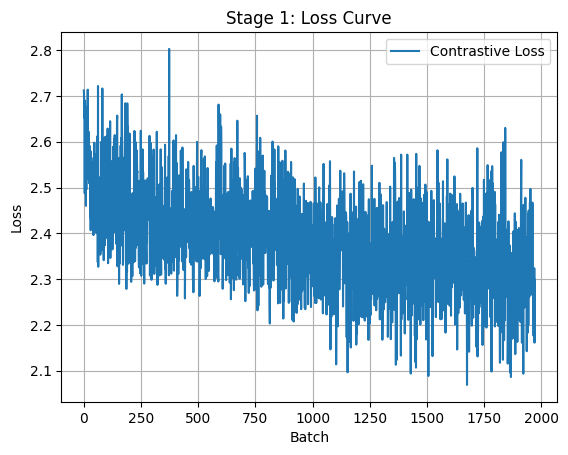

=== Stage 2: Language Model Pretraining ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Stage 2: Training 1,882,306,048 parameters


Stage2 Epoch 1:   0%|          | 0/68 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 11.38 MiB is free. Process 114756 has 22.14 GiB memory in use. Of the allocated memory 21.16 GiB is allocated by PyTorch, and 758.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:

alm_cfg = ALMConfig()
train_cfg = TrainConfig()

# trained_model = train(train_cfg, alm_cfg)
stage1_model = train_step1_alignment(train_cfg, alm_cfg)



stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)
final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)
# stage1_model, stage2_model, final_model = train_three_stages(train_cfg, alm_cfg)

stage1_model.save_pretrained("/content/")
stage2_model.save_pretrained("/content/")
final_model.save_pretrained("/content/")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

### Test

In [ ]:
!cp /content/drive/MyDrive/nanoALM/output_txt1.wav /content/output_txt1.wav
!cp /content/drive/MyDrive/nanoALM/output_txt2.wav /content/output_txt2.wav
!cp /content/drive/MyDrive/nanoALM/output_txt3.wav /content/output_txt3.wav

In [ ]:
!cp ../model.safetensors /content/drive/MyDrive/nanoALM/model.safetensors
!cp ../config.json /content/drive/MyDrive/nanoALM/config.json
!cp ./model.safetensors /content/drive/MyDrive/nanoALM
!cp ./config.json /content/drive/MyDrive/nanoALM

In [ ]:
# final_model.save_pretrained("/content/")
!python generate.py --checkpoint ../ --audio ../output_txt1.wav

In [ ]:
!python generate.py --checkpoint ../ --audio ../output_txt2.wav

In [ ]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav

In [ ]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav